In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import optuna
import optuna.visualization as vis
import gc
import os
from typing import Tuple, Optional
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, SpatialDropout2D,GlobalAveragePooling2D, Activation
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.applications.resnet50 import preprocess_input


2025-05-09 01:15:46.798359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746742546.868057   37668 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746742546.890284   37668 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746742547.034747   37668 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746742547.034777   37668 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746742547.034779   37668 computation_placer.cc:177] computation placer alr

In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


***
## Data Preparation
***

In [3]:
def create_tensors(data_dir, 
                   img_height = 224, 
                   img_width = 224, 
                   batch_size = 8
                   ) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    """
    Creates training and validation image datasets from a directory of images.

    Args:
        data_dir (str): Path to the root directory containing subdirectories of images, one per class.
        img_height (int): Target height of the images after resizing.
        img_width (int): Target width of the images after resizing.
        batch_size (int): Number of samples per batch.

    Returns:
        Tuple[tf.data.Dataset, tf.data.Dataset]: A tuple containing
            - train_ds: the training dataset
            - val_ds: the validation dataset
    """
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training",     
    seed=123,              
    image_size=(img_height, img_width), 
    batch_size=batch_size, 
    label_mode='int'      
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='int'
    )
    

    #Tune for higher performance
    AUTOTUNE = tf.data.AUTOTUNE
    
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds

In [4]:
def normalize_tensor(data: tf.data.Dataset) -> tf.data.Dataset:
    """
    Normalizes the tensors.

    Args:
        data(tf.data.Dataset): Unnormalized dataset

    Returns:
        data(tf.data.Dataset): Normalized dataset

    Raises:
        ValueError: If the input dataset appears to be already normalized
                    (max value <= 1.0 and min value >= 0.0 in the first image
                     of the first batch).
        tf.errors.OutOfRangeError: If the input dataset `data` is empty and cannot be checked.
    """ 

    # Check if already normalized
    first_batch_ds = data.take(1)
    image_batch, _ = next(iter(first_batch_ds)) 

    first_image = image_batch[0]

    min_val = tf.reduce_min(first_image)
    max_val = tf.reduce_max(first_image)

    if max_val <= 1.0 and min_val >= 0.0:
        raise ValueError(
            "This data seems already Normalized"
        )

    #Normalization
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    normalized_tensor = data.map(lambda x, y: (normalization_layer(x), y))
    
    return normalized_tensor

In [5]:
train_ds, val_ds = create_tensors("alpaca_and_others_dataset/dataset")

Found 782 files belonging to 5 classes.
Using 626 files for training.


I0000 00:00:1746721087.911370  241348 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2604 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 782 files belonging to 5 classes.
Using 156 files for validation.


2025-05-06 20:04:54.654797: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


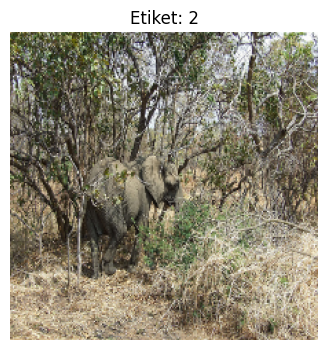

In [6]:
#take a batch
first_batch_ds = val_ds.take(1)
#fetch the batch 
image_batch, label_batch = next(iter(first_batch_ds))

#plot the image
plt.figure(figsize=(4, 4))
plt.imshow(image_batch[5].numpy().astype("uint8"))
plt.title(f"Etiket: {label_batch[5].numpy()}")
plt.axis("off")
plt.show()

In [7]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
normalized_train_ds = normalize_tensor(train_ds)
normalized_val_ds = normalize_tensor(val_ds)

2025-05-08 19:18:11.010910: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:
first_batch_ds = normalized_train_ds.take(1)
#fetch the batch 
image_batch, label_batch = next(iter(first_batch_ds))
image_batch[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.00114264, 0.00114264, 0.00114264],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.7836603 , 0.5304512 , 0.43433177],
        [0.8018976 , 0.5530879 , 0.45504865],
        [0.8026553 , 0.5654702 , 0.46445486]],

       [[0.00139712, 0.00139712, 0.00139712],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.82207406, 0.5651954 , 0.46430287],
        [0.79822904, 0.54207045, 0.4397205 ],
        [0.7810754 , 0.54243004, 0.43342805]],

       [[0.00118454, 0.00118454, 0.00118454],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.841262  , 0.59058124, 0.48064786],
        [0.8538709 , 0.6061466 , 0.4952573 ],
        [0.82171583, 0.58893067, 0.47222903]],

       ...,

       [[0.5504707 , 0.48380402, 0.40537265],
        [0.55

In [10]:
#Ensure for normalization
max_val_image = tf.reduce_max(image_batch[0])
max_val_image

<tf.Tensor: shape=(), dtype=float32, numpy=0.9983888268470764>


## Model Definition
***
### Methods
* I have added l2 regularization and dropout for regularize the output. First model was very disposed to overfitting but adding this layers affected a lot.  
* I was thinking that adding dropout at to the last of the code would add dropout to all layer but for convolutional layers I should add the spatial dropout. Before I did not add this I get nearly 1 training accuracy but just 0.65 validation accuracy, when I add spatial dropout to all layers I get more realistic training values.  
* I have used adam as optimizer. Model have 3 convolutional units and 1 fully connected layer. It has a simple architecture. I have tried to make it simpler to avoid overfitting but it still overfits. 
* I observe that avoiding overfiting a lot reduces the validation accuracy of the model so that I ignore this overfitting a bit to maximize validation accuracy.

***




In [5]:
def create_model(model_name: str,
                lr: float,
                l2_lambda: float,
                spatial_dropout_rate: float,
                dense_units: int,
                dense_dropout_rate: float,
                ) -> Sequential:


    """
    Creates and compiles a CNN classification model with the specified hyperparameters.

    The network consists of three convolutional blocks (with Conv2D → BatchNorm → ReLU →
    optional SpatialDropout2D → MaxPooling), followed by flattening, a fully connected
    hidden layer, and a softmax output layer for 5 classes.

    Args:
        model_name (str):
            A name to assign to the Keras Sequential model.
        lr (float):
            Learning rate for the Adam optimizer.
        l2_lambda (float):
            L2 regularization coefficient applied to Conv2D and Dense layers.
        spatial_dropout_rate (float):
            Dropout rate for SpatialDropout2D layers in the convolutional blocks.
        dense_units (int):
            Number of neurons in the intermediate Dense layer before the output.
        dense_dropout_rate (float):
            Dropout rate for the Dropout layers applied before and after the Dense unit.

    Returns:
        tf.keras.Sequential:
            A compiled Keras Sequential model ready for training.
    """
    model = Sequential(name=model_name)

    #Conv layer 1
    model.add(Conv2D(32, (7,7), padding='same', strides=2,
                    kernel_regularizer=regularizers.l2(l2_lambda),
                    input_shape=(224,224,3))) 
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(MaxPooling2D())

    #Conv layer 2
    model.add(Conv2D(64, (5,5), padding='same',strides=2,kernel_regularizer=regularizers.l2(l2_lambda))) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(SpatialDropout2D(spatial_dropout_rate))
    model.add(MaxPooling2D())

    #Conv layer 3
    model.add(Conv2D(128, (3,3), padding='same',kernel_regularizer=regularizers.l2(l2_lambda))) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(SpatialDropout2D(spatial_dropout_rate))
    model.add(MaxPooling2D())

    #Flatten
    model.add(Flatten())
    model.add(Dropout(dense_dropout_rate))

    #Dense Layer
    model.add(Dense(dense_units, activation='relu',kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(Dropout(dense_dropout_rate))
    model.add(Dense(5, activation='softmax'))

    #Model compiler
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                metrics=['accuracy']
                )

    model.summary()
    return model


In [6]:
def train_model(data_dir: str, 
                 model_name: str,
                 lr: float,
                 l2_lambda: float,
                 batch_size: int,
                 spatial_dropout_rate: float,
                 dense_units: int,
                 dense_dropout_rate: float,
                 num_epochs: int,
                 logdir: str = 'logs'
                   ) -> tf.keras.callbacks.History:
    """
    Load images, build a CNN, and train with TensorBoard logging and early stopping.

    Args:
        data_dir (str): Root folder of class-subdirectories.
        model_name (str): Identifier for the model and log subfolder.
        lr (float): Adam learning rate.
        l2_lambda (float): L2 regularization factor.
        batch_size (int): Samples per batch.
        spatial_dropout_rate (float): SpatialDropout2D rate.
        dense_units (int): Units in the hidden Dense layer.
        dense_dropout_rate (float): Dropout rate around the Dense layer.
        num_epochs (int): Max training epochs.
        logdir (str): Base path for TensorBoard logs.

    Returns:
        tf.keras.callbacks.History: Training history with metrics.
    """

    #Create tensors from data
    train_ds_raw, val_ds_raw = create_tensors(data_dir=data_dir, batch_size=batch_size)

    #Normalization via a function
    train_data = normalize_tensor(train_ds_raw)
    val_data = normalize_tensor(val_ds_raw)
    
    model = create_model(model_name=model_name,
                         lr=lr,
                         l2_lambda=l2_lambda,
                         spatial_dropout_rate=spatial_dropout_rate,
                         dense_units=dense_units,
                         dense_dropout_rate=dense_dropout_rate,

                         )
    
    #Save logs.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"{logdir}/{model_name}", histogram_freq=1)

    # Stops training when 'val_accuracy' stops improving for 'patience' epochs.
    early_stopping_callback = EarlyStopping(
        monitor='val_accuracy',     
        patience=15,                
        verbose=1,                  
        mode='max',                 
        restore_best_weights=True   
    )
    
    #Train the model and get the history.
    hist = model.fit(train_data, 
                     epochs=num_epochs, 
                     validation_data=val_data, 
                     callbacks=[tensorboard_callback,early_stopping_callback],
                     verbose=1)
    
    return hist



# Hyperparameter Tuning
***
* I have added hyperparameter tuning with using optuna tool it is very useful and popular tool for hyperparameter tuning. It uses more sophisticated methods than random tuning.  
* I do not add every hyperparameter to avoiding creating a more complex model and also I have limited computational power. I do not change the architecture of my model. Just tuned other important parameters.  
***

In [7]:
def objective(trial: optuna.trial.Trial, 
              data_dir: str, 
              model_name: str, 
              num_epochs: int
              ) -> float:
    """
    Optuna objective function: suggests hyperparameters, trains the model, and returns its best validation accuracy.

    Args:
        trial (optuna.trial.Trial): Optuna trial object for hyperparameter suggestions.
        data_dir (str): Root directory of the image dataset (with class subfolders).
        model_name (str): Base name for the model and its log directory.
        num_epochs (int): Maximum number of epochs to train.

    Returns:
        float: Maximum validation accuracy achieved during training.

    Raises:
        optuna.exceptions.TrialPruned: If training fails or an exception is raised.
    """

    tf.keras.backend.clear_session()
    gc.collect()
    
    # Suggest hyperparameter via optuna.trial
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    l2_lambda = trial.suggest_float("l2_lambda", 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    spatial_dropout_rate = trial.suggest_float("spatial_dropout_rate", 0.1, 0.5)
    dense_dropout_rate = trial.suggest_float("dense_dropout_rate", 0.2, 0.6)
    dense_units = trial.suggest_categorical("dense_units", [64, 128, 256, 512])

    try:
        # Train the model with parameters.
        history = train_model(
            data_dir=data_dir,
            model_name=f"{model_name}_trial_{trial.number}", 
            lr=lr,
            l2_lambda=l2_lambda,
            batch_size=batch_size,
            spatial_dropout_rate=spatial_dropout_rate,
            dense_units=dense_units,
            dense_dropout_rate=dense_dropout_rate,
            num_epochs=num_epochs
        )


        metric = max(history.history['val_accuracy'])

        return metric

    except Exception as e:
        print(f"Trial {trial.number} failed with error: {e}")
        raise optuna.exceptions.TrialPruned(f"Error while training: {e}")

In [ ]:
DATA_DIRECTORY = "alpaca_and_others_dataset/dataset" 
NUM_EPOCHS = 50 
N_TRIALS = 50   
MODEL_NAME = "optuna_2"

study = optuna.create_study(
    direction="maximize", 
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10, interval_steps=1) 
)

study.optimize(
    lambda trial: objective(trial, DATA_DIRECTORY, MODEL_NAME, NUM_EPOCHS),
    n_trials=N_TRIALS,
    timeout=None, 
    gc_after_trial=True 
)

completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

if not completed_trials:
    print("No trials completed successfully.")
else:
    print(f"Number of finished trials (all states): {len(study.trials)}")
    print(f"Number of completed trials: {len(completed_trials)}")

    print("\nBest trial:")
    best_trial = study.best_trial 

    print(f"  Trial Number: {best_trial.number}")
    print(f"  Value (Max Validation Accuracy): {best_trial.value:.4f}")

    print("  Best Hyperparameters: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    print("\nConsider training a final model using these hyperparameters, potentially")
    print("with the full dataset and possibly more epochs if early stopping")
    print("triggered very early in the best trial.")

In [3]:
import joblib
#joblib.dump(study, "study.joblib")

In [4]:
study = joblib.load("study.joblib")

In [5]:
study

# Tuning Results

In [ ]:
#Lets observe the importance of hyperparameters.
importance_fig = vis.plot_param_importances(study)
importance_fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [spatial_dropout_rate (FloatDistribution):
                                0.04196059234380787<extra></extra>, dense_units
                                (CategoricalDistribution):
                                0.06697581585740237<extra></extra>,
                                dense_dropout_rate (FloatDistribution):
                                0.10198607969197651<extra></extra>, lr
                                (FloatDistribution):
                                0.13544388138975835<extra></extra>, l2_lambda
                                (FloatDistribution):
                                0.2551613930779468<extra></extra>, batch_size
                                (CategoricalDistribution):
                                0.3984722376391081<extra></extra>],
              'name': 'Objective Value',
              'orientation': 'h',
              'text': [0.04, 0.07, 0.10, 0.14, 0.26, 0.40],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.04196059234380787, 0.06697581585740237, 0.10198607969197651,
                    0.13544388138975835, 0.2551613930779468, 0.3984722376391081],
              'y': [spatial_dropout_rate, dense_units, dense_dropout_rate, lr,
                    l2_lambda, batch_size]}],
    'layout': {'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Hyperparameter Importance'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

Most important metric is batch_size and l2_lambda as we can observe.

In [ ]:
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

#Sort trial results to observe the most successfull ones.
sorted_trials = sorted(completed_trials, key=lambda t: t.value, reverse=True)
direction_str = "Minimize (En Kötüler Başa)"

# The most successfull 5 models.
top_n = 10
top_trials = sorted_trials[:top_n]

#Print values
for i, trial in enumerate(top_trials):
    print(f"\n--- Sıra: {i+1} ---")
    print(f"  Trial Numarası: {trial.number}")
    print(f"  Değer (Value): {trial.value:.4f}")

    for key, value in trial.params.items():
        if isinstance(value, float):
                print(f"    {key}: {value:.6f}") 
        else:
                print(f"    {key}: {value}")


--- Sıra: 1 ---
  Trial Numarası: 1
  Değer (Value): 0.8750
    lr: 0.000555
    l2_lambda: 0.000112
    batch_size: 8
    spatial_dropout_rate: 0.481545
    dense_dropout_rate: 0.439470
    dense_units: 128

--- Sıra: 2 ---
  Trial Numarası: 24
  Değer (Value): 0.8750
    lr: 0.000111
    l2_lambda: 0.001406
    batch_size: 8
    spatial_dropout_rate: 0.109571
    dense_dropout_rate: 0.390269
    dense_units: 128

--- Sıra: 3 ---
  Trial Numarası: 26
  Değer (Value): 0.8750
    lr: 0.000143
    l2_lambda: 0.000228
    batch_size: 8
    spatial_dropout_rate: 0.195304
    dense_dropout_rate: 0.429615
    dense_units: 128

--- Sıra: 4 ---
  Trial Numarası: 31
  Değer (Value): 0.8750
    lr: 0.000263
    l2_lambda: 0.000874
    batch_size: 8
    spatial_dropout_rate: 0.198384
    dense_dropout_rate: 0.387947
    dense_units: 128

--- Sıra: 5 ---
  Trial Numarası: 32
  Değer (Value): 0.8750
    lr: 0.000397
    l2_lambda: 0.000603
    batch_size: 8
    spatial_dropout_rate: 0.257280
    d

# Graph Results for best models
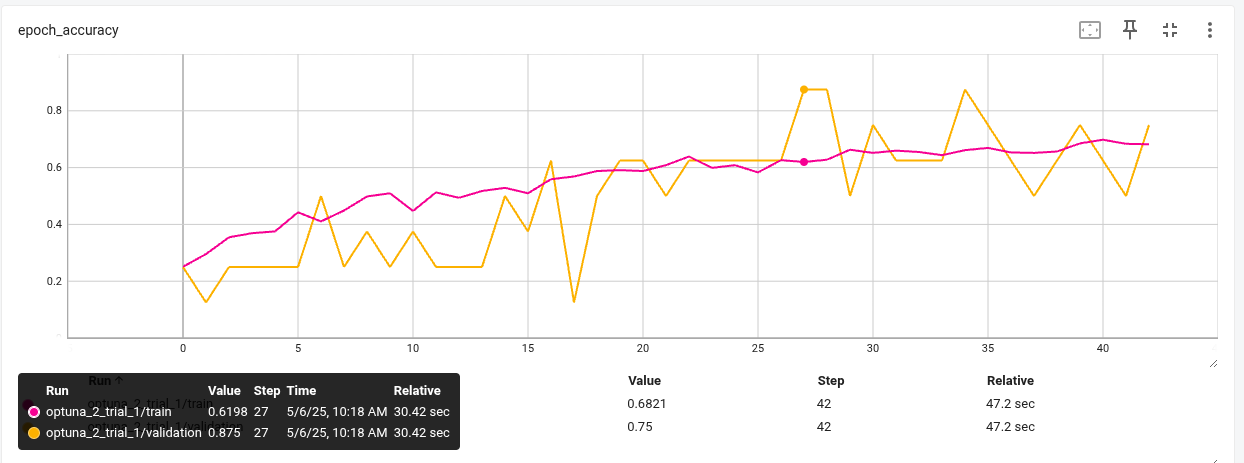

For trial 1 it says 0.875 but outputs seems very suspicious. Val accuracy is very high event higher than train accuracy which is non-realistic. Actually val accuracy act like val dataset has 8 value in it (when batch size is 8). Validation accuracy values are multiples of 1/8 in that type of models. I could not find the solution for that. So i decided to ignore this type of unrealistic models.

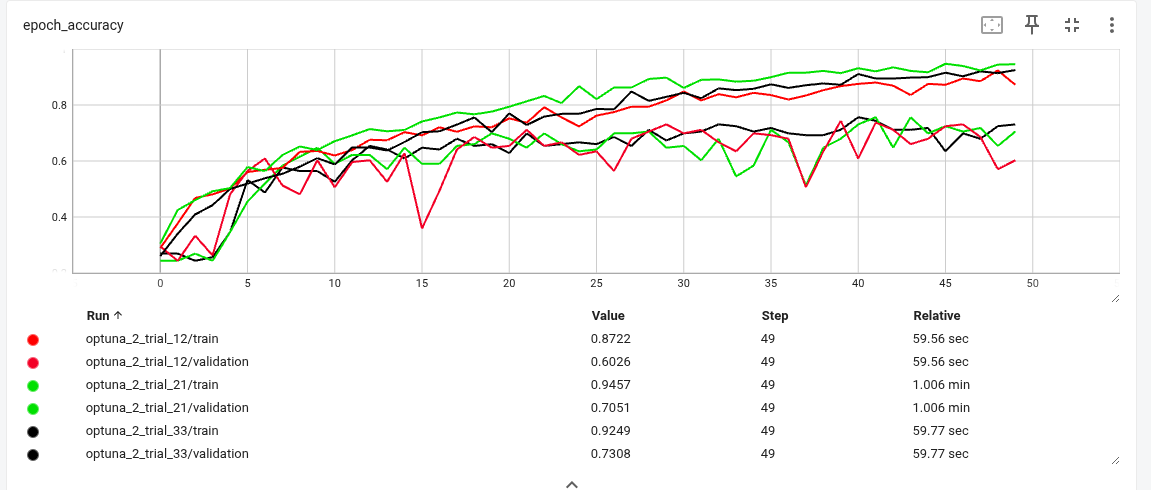

These are the best three models when I ignore other models:

--- Sıra: 7 ---  
  Trial Numarası: 21  
  Değer (Value): 0.7564  
    lr: 0.000243  
    l2_lambda: 0.004908  
    batch_size: 8  
    spatial_dropout_rate: 0.192053  
    dense_dropout_rate: 0.384483  
    dense_units: 128  

--- Sıra: 8 ---  
  Trial Numarası: 33  
  Değer (Value): 0.7564  
    lr: 0.000138  
    l2_lambda: 0.000391  
    batch_size: 8  
    spatial_dropout_rate: 0.191880  
    dense_dropout_rate: 0.401940  
    dense_units: 128    

--- Sıra: 10 ---  
  Trial Numarası: 12  
  Değer (Value): 0.7436  
    lr: 0.000410  
    l2_lambda: 0.004003  
    batch_size: 8  
    spatial_dropout_rate: 0.214831  
    dense_dropout_rate: 0.371794  
    dense_units: 128    

They all seems good but I decided to choose trial 33 because it has a low learning rate which seems more trainable than others.

# Best Hyperparameters Selection

We will chose the best one that does not contains any problem in it. Between them I will chose the most regularized parameters.

In [16]:
#Train for trial 33 parameters.
hist = train_model(
    model_name="successed_opt_1",
    data_dir="alpaca_and_others_dataset/dataset",
    lr=0.000138,
    l2_lambda=0.000391,
    batch_size=8,
    spatial_dropout_rate=0.191880,
    dense_dropout_rate=0.401940,
    dense_units= 128,
    num_epochs=70
)

Found 782 files belonging to 5 classes.
Using 626 files for training.
Found 782 files belonging to 5 classes.
Using 156 files for validation.


2025-05-08 18:23:59.987871: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/home/tako/Documents/506hw/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "successed_opt_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 28, 28, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 14, 14, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 934,341 (3.56 MB)

 Trainable params: 933,893 (3.56 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/70
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.2771 - loss: 2.7550 - val_accuracy: 0.2244 - val_loss: 1.7522
Epoch 2/70
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3654 - loss: 1.6694 - val_accuracy: 0.1667 - val_loss: 1.8799
Epoch 3/70
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4055 - loss: 1.5658 - val_accuracy: 0.1603 - val_loss: 1.8871
Epoch 4/70
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4799 - loss: 1.3770 - val_accuracy: 0.1667 - val_loss: 1.8639
Epoch 5/70
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5118 - loss: 1.3116 - val_accuracy: 0.2692 - val_loss: 1.8638
Epoch 6/70
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5239 - loss: 1.2934 - val_accuracy: 0.4808 - val_loss: 1.4671
Epoch 7/70
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5095 - loss: 1.2997 - val_accuracy: 0.5192 - val_loss: 1.2654
Epoch 8/70
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5118 - loss: 1.2365 - val_accuracy: 0.5705 - 

#### The accuracy of my model: 
* training accuracy: 0.9113
* validation accuracy: 0.7436
* validation loss: 0.9983

In [8]:
def plot_accuracy_and_loss(hist):
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

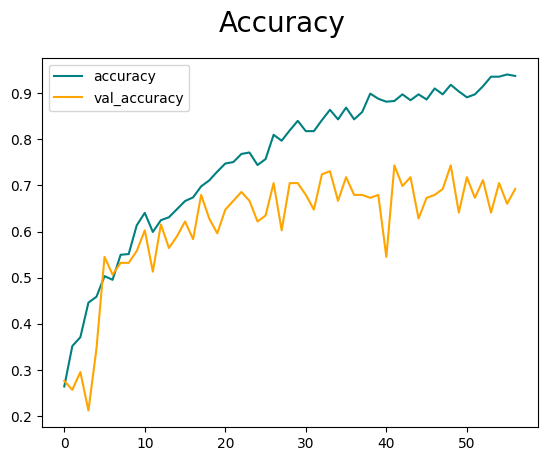

In [18]:
plot_accuracy_and_loss(hist)


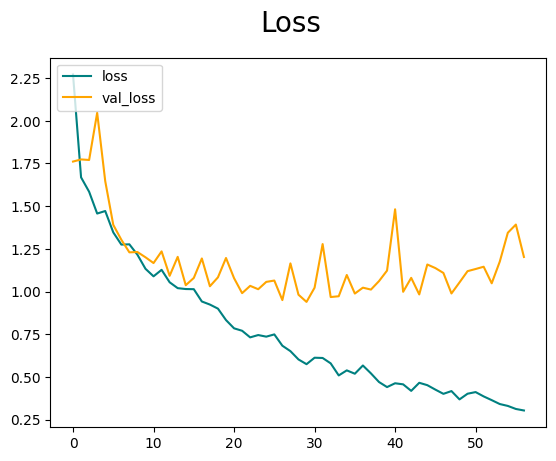

# Transfer Learning

***
### Hyperparameters
I have used different values on Transfer Learning because I do not need to train it with high epochs and the hyperparameters I have used on my first model which I trained from scratch may not be suitable for transfer learning. I think even if I have used different parameters. I can observe a controlled experiment. No need to tune the hyperparameters there is already a few hyperparameters and I get a higher accuracy.
***

In [9]:
input_shape = (224, 224, 3)  
epochs = 10
batch_size= 8

def transfer_learning_model(
        base_model, 
        num_classes=5, 
        l2_lambda=0.01, 
        learning_rate=0.001):
    """
    Creates a classification model by adding a custom head to a base model,
    compiles it, and prints the model summary.

    Args:
        base_model (tf.keras.Model): The pre-trained base model.
        num_classes (int): The number of output classes for the classification task.
        l2_lambda (float): The L2 regularization factor for the Dense layer.
        learning_rate (float): The learning rate for the Adam optimizer.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

***
### VGG

In [9]:
VGG16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in VGG16_base.layers:
    layer.trainable = False

VGG_model = transfer_learning_model(base_model=VGG16_base)

# Training
history = VGG_model.fit(
    normalized_train_ds,
    epochs=epochs,
    validation_data=normalized_val_ds,
)

VGG_model.save('vgg16_transfer_learning_model.h5')


Epoch 1/10


I0000 00:00:1746553051.037874  133562 service.cc:152] XLA service 0x7f40c000f290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746553051.037946  133562 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-05-06 20:37:31.078060: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746553051.427592  133562 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-06 20:37:32.009426: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[32,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0} %bitcast.3617, f32[64,3,3,3]{3,2,1,0} %bitcast.3624, f32[64]{0} %bitcast.3626), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_tar

13/20 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.2798 - loss: 7.5035

2025-05-06 20:37:47.940933: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[18,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,3,224,224]{3,2,1,0} %bitcast.3617, f32[64,3,3,3]{3,2,1,0} %bitcast.3624, f32[64]{0} %bitcast.3626), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/block1_conv1_1/convolution" source_file="/home/tako/Documents/506hw/myenv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-06 20:37:48.266791: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.c

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.3437 - loss: 6.7886

2025-05-06 20:38:01.109085: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[28,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,3,224,224]{3,2,1,0} %bitcast.832, f32[64,3,3,3]{3,2,1,0} %bitcast.839, f32[64]{0} %bitcast.841), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/block1_conv1_1/convolution" source_file="/home/tako/Documents/506hw/myenv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-06 20:38:01.259942: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3509 - loss: 6.7073 - val_accuracy: 0.7564 - val_loss: 2.8771
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.7901 - loss: 2.5737 - val_accuracy: 0.8397 - val_loss: 2.0107
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - accuracy: 0.8952 - loss: 1.7196 - val_accuracy: 0.8333 - val_loss: 1.5420
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - accuracy: 0.9367 - loss: 1.2447 - val_accuracy: 0.8654 - val_loss: 1.2074
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.9354 - loss: 0.9595 - val_accuracy: 0.8077 - val_loss: 1.1554
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.9575 - loss: 0.7889 - val_accuracy: 0.8590 - val_loss: 0.9195
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.9737 - loss: 0.6531 - val_accuracy: 0.8846 - val_loss: 0.8196
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - accuracy: 0.9603 - loss: 0.5817 - val_accuracy: 0.8462 - val_lo

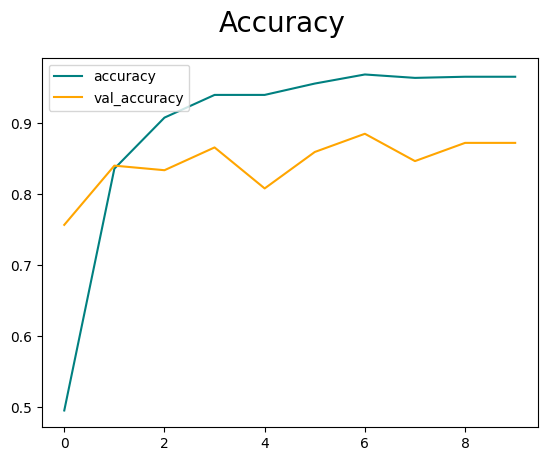

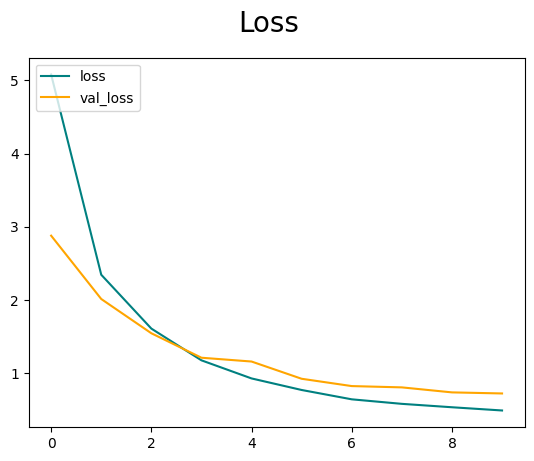

In [10]:
plot_accuracy_and_loss(history)

### Results

We get maximum 0.91 validation accuracy with VGG net as we expected. We just added a simple layer to the VGG with removing it's orijinal last year and get a higher accuracy with less work.

***
### ResNet50

In [ ]:
ResNet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape,pooling="avg")

for layer in ResNet50_base.layers:
    layer.trainable = False

ResNet50_model = transfer_learning_model(base_model=ResNet50_base)
tf.keras.backend.clear_session()
gc.collect()


# We must add this additional preprocessing step for resnet because we get a problem with just giving the normalized input.
def normalize_and_preprocess(ds):
    return ds.map(lambda x, y: (preprocess_input(x), y),
                  num_parallel_calls=tf.data.AUTOTUNE)

raw_train, raw_val = create_tensors("alpaca_and_others_dataset/dataset")
train_ds = normalize_and_preprocess(raw_train) \
               .cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds   = normalize_and_preprocess(raw_val) \
               .cache().prefetch(tf.data.AUTOTUNE)
# Training
history = ResNet50_model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

ResNet50_model.save('ResNet50_transfer_learning_model.h5')

Found 782 files belonging to 5 classes.
Using 626 files for training.
Found 782 files belonging to 5 classes.
Using 156 files for validation.
Epoch 1/10


2025-05-06 20:39:15.890568: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.162 = (f32[32,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,56,56]{3,2,1,0} %bitcast.7653, f32[64,64,3,3]{3,2,1,0} %bitcast.7660, f32[64]{0} %bitcast.7662), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2_block1_2_conv_1/convolution" source_file="/home/tako/Documents/506hw/myenv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-06 20:39:16.561650: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_

 5/20 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.4333 - loss: 6.1444

2025-05-06 20:39:22.710011: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.162 = (f32[18,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,64,56,56]{3,2,1,0} %bitcast.7653, f32[64,64,3,3]{3,2,1,0} %bitcast.7660, f32[64]{0} %bitcast.7662), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2_block1_2_conv_1/convolution" source_file="/home/tako/Documents/506hw/myenv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-06 20:39:23.108918: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.6900 - loss: 5.2442

2025-05-06 20:39:32.927960: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.162 = (f32[28,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,64,56,56]{3,2,1,0} %bitcast.4862, f32[64,64,3,3]{3,2,1,0} %bitcast.4869, f32[64]{0} %bitcast.4871), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2_block1_2_conv_1/convolution" source_file="/home/tako/Documents/506hw/myenv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-06 20:39:33.507720: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_

20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 857ms/step - accuracy: 0.6978 - loss: 5.2099 - val_accuracy: 0.9679 - val_loss: 3.6943
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.9805 - loss: 3.3711 - val_accuracy: 0.9936 - val_loss: 2.7064
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9871 - loss: 2.5246 - val_accuracy: 0.9744 - val_loss: 2.0477
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9942 - loss: 1.8706 - val_accuracy: 0.9872 - val_loss: 1.5191
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 1.0000 - loss: 1.3936 - val_accuracy: 0.9808 - val_loss: 1.1737
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.0620 - val_accuracy: 0.9872 - val_loss: 0.8955
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 0.8127 - val_accuracy: 0.9872 - val_loss: 0.6957
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 0.6279 - val_accuracy: 0.9808 - val

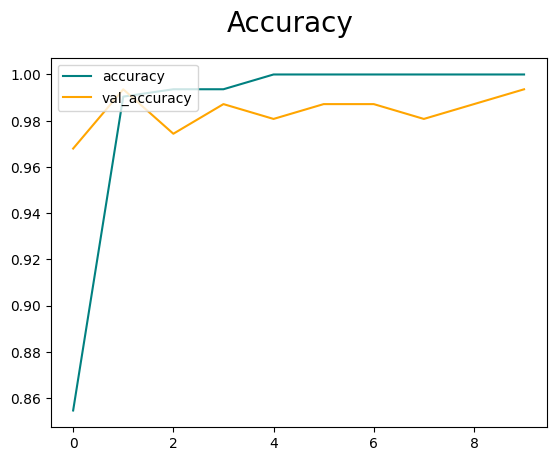

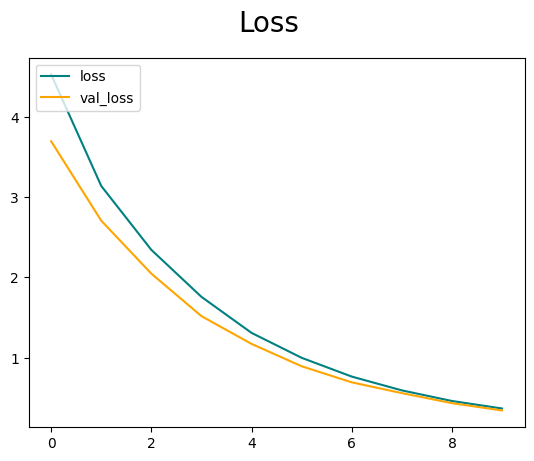

In [12]:
plot_accuracy_and_loss(history)

*** 
### Results
We get a very high validation accuracy which is 0.99 with resnet because it is deeper than VGG and has very high parameters.

***

# Data Augmentation

I have applied some basic data augmentation methods to increase my data. 
* Random Flip: Flips the image vertically or horizontally
* Random Rotation: Rotate the image with a random angle
* Random Zoom: Zooms the image with a random scale
* Random Contrast: Give a color contrast in a random interval.

I have applied 5 random operations on images and saved to another folder.

In [ ]:
import uuid
import shutil
from pathlib import Path
import tensorflow as tf
from tqdm import tqdm          

root_dir   = Path("alpaca_and_others_dataset/dataset/").expanduser()
output_dir = Path("datasets/my_images_aug").expanduser()
n_aug        = 5
img_format   = "jpg"
target_size  = (224, 224)       
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# I saved the original images too.
def copy_original(img_path: Path, save_dir: Path):
    dest = save_dir / img_path.name
    if dest.exists():
        dest = save_dir / f"orig_{uuid.uuid4().hex}_{img_path.name}"
    shutil.copy2(img_path, dest)      

#augment times augmentation process
def augment_and_save(img_path: Path, save_dir: Path):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    x   = tf.expand_dims(tf.keras.utils.img_to_array(img), 0)   

    for _ in range(n_aug):
        aug = augment(x, training=True)[0].numpy().astype("uint8")
        out_name = f"{uuid.uuid4().hex}.{img_format}"
        tf.keras.utils.save_img(save_dir / out_name, aug)


if not root_dir.is_dir():
    raise FileNotFoundError(f"root_dir bulunamadı: {root_dir}")

for class_dir in root_dir.iterdir():
    if not class_dir.is_dir():
        continue

    img_paths = list(class_dir.glob("*"))
    if not img_paths:
        print(f"⏩  {class_dir.name}: boş, atlanıyor")
        continue

    save_dir = output_dir / class_dir.name
    try:
        save_dir.mkdir(parents=True, exist_ok=True)
    except Exception as e:
        continue

    print(f"▶  {class_dir.name:15} | {len(img_paths)} image")

    for img_path in tqdm(img_paths, desc=f"  ➜ {class_dir.name}"):
        copy_original(img_path, save_dir)      
        augment_and_save(img_path, save_dir)    



▶  bear            | 160 görsel


  ➜ bear: 100%|██████████| 160/160 [00:17<00:00,  9.05it/s]


▶  alpaca          | 142 görsel


  ➜ alpaca: 100%|██████████| 142/142 [00:16<00:00,  8.82it/s]


▶  elephant        | 160 görsel


  ➜ elephant: 100%|██████████| 160/160 [00:17<00:00,  9.11it/s]


▶  zebra           | 160 görsel


  ➜ zebra: 100%|██████████| 160/160 [00:17<00:00,  9.26it/s]


▶  leopard         | 160 görsel


  ➜ leopard: 100%|██████████| 160/160 [00:17<00:00,  9.27it/s]

✅ Orijinaller + augmentasyonlar kaydedildi


***
## With my simple architecture

In [10]:
# I trained the new model with all same parameters and with all same model 
# which I trained first to observe a controlled experiment.
hist = train_model(
    model_name="augmented_opt_1",
    data_dir="datasets/my_images_aug",
    lr=0.000138,
    l2_lambda=0.000391,
    batch_size=8,
    spatial_dropout_rate=0.191880,
    dense_dropout_rate=0.401940,
    dense_units= 128,
    num_epochs=70
)

Found 4692 files belonging to 5 classes.
Using 3754 files for training.


I0000 00:00:1746738803.497627    4618 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2604 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 4692 files belonging to 5 classes.
Using 938 files for validation.


2025-05-09 00:13:28.081585: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
/home/tako/Documents/506hw/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "augmented_opt_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 28, 28, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 14, 14, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 934,341 (3.56 MB)

 Trainable params: 933,893 (3.56 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/70


I0000 00:00:1746738810.888663    5414 service.cc:152] XLA service 0x7f3c28002eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746738810.888700    5414 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-05-09 00:13:31.003048: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746738811.387599    5414 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-09 00:13:32.180816: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.13 = (f32[8,128,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,14,14]{3,2,1,0} %bitcast.15194, f32[128,64,3,3]{3,2,1,0} %bitcast.13816, f32[128]{0} %bitcast.15255), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_t

 10/470 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1341 - loss: 3.5603    

I0000 00:00:1746738816.410747    5414 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


359/470 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2654 - loss: 2.2162

2025-05-09 00:13:41.442891: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.13 = (f32[2,128,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,64,14,14]{3,2,1,0} %bitcast.15197, f32[128,64,3,3]{3,2,1,0} %bitcast.13818, f32[128]{0} %bitcast.15258), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="augmented_opt_1_1/conv2d_2_1/convolution" source_file="/home/tako/Documents/506hw/myenv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


470/470 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.2775 - loss: 2.1155 - val_accuracy: 0.3113 - val_loss: 1.7034
Epoch 2/70
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.4060 - loss: 1.4823 - val_accuracy: 0.4819 - val_loss: 1.2151
Epoch 3/70
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4647 - loss: 1.3364 - val_accuracy: 0.5256 - val_loss: 1.2147
Epoch 4/70
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5429 - loss: 1.2284 - val_accuracy: 0.5704 - val_loss: 1.1349
Epoch 5/70
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5553 - loss: 1.1865 - val_accuracy: 0.6055 - val_loss: 1.0989
Epoch 6/70
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5852 - loss: 1.1356 - val_accuracy: 0.6386 - val_loss: 1.0243
Epoch 7/70
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6009 - loss: 1.1125 - val_accuracy: 0.6450 - val_loss: 0.9569
Epoch 8/70
470/470 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6226 - loss: 1.0654 - val_accuracy: 0.65

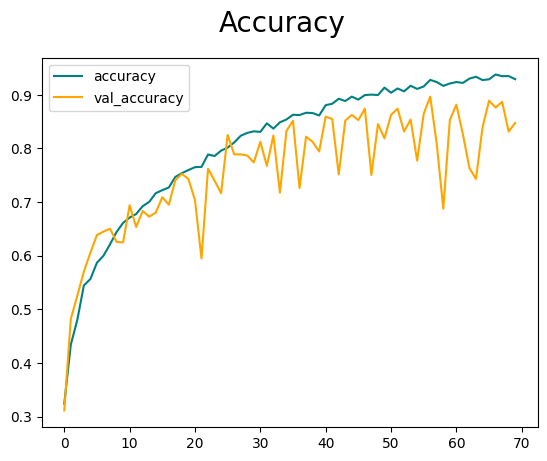

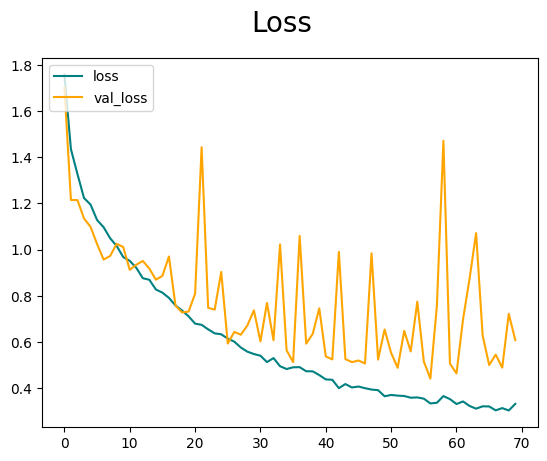

In [11]:
plot_accuracy_and_loss(hist)

As we can observe here the validation accuracy increased from 0.74 to 0.89 which is a pretty good value for a 1 mn parameter basic architecture.  
We just changed the data amount with augmentation.
***

# Data Augmentation & Transfer Learning

In [10]:
# Create the datasets again
augmented_train_ds, augmented_val_ds = create_tensors("datasets/my_images_aug")

Found 4692 files belonging to 5 classes.
Using 3754 files for training.


I0000 00:00:1746742591.199173   37668 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2604 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 4692 files belonging to 5 classes.
Using 938 files for validation.


## With VGG

In [11]:
from tensorflow.keras.applications.vgg16 import preprocess_input
VGG16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in VGG16_base.layers:
    layer.trainable = False

VGG_model = transfer_learning_model(base_model=VGG16_base)

# We need a different preprocessing method to apply appropriate caching to
# my model because if i use cache like before it can be problematic because
# of data augmentation, and if I do not use caching I cannot train with my
# gpu beacuse of its limitations. So I found that solution.
AUTOTUNE = tf.data.AUTOTUNE
CACHE_TRAIN = "/tmp/resnet50_train.cache"   
CACHE_VAL   = "/tmp/resnet50_val.cache"

def add_preprocess(ds):
    return ds.map(lambda x, y: (preprocess_input(x), y),
                  num_parallel_calls=AUTOTUNE)

CACHE_DIR = "/tmp/tf_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

train_ds = (add_preprocess(augmented_train_ds)
            .cache(os.path.join(CACHE_DIR, "train.cache"))
            .shuffle(1000)
            .prefetch(AUTOTUNE))

val_ds   = (add_preprocess(augmented_val_ds)
            .cache(os.path.join(CACHE_DIR, "val.cache"))
            .prefetch(AUTOTUNE))

# Training
history = VGG_model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

VGG_model.save('vgg16_transfer_learning_model.h5')

Epoch 1/10


I0000 00:00:1746742598.217306   38258 service.cc:152] XLA service 0x7fe05c00ed70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746742598.217335   38258 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-05-09 01:16:38.255341: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746742598.632623   38258 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-09 01:16:39.119989: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[8,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,224,224]{3,2,1,0} %bitcast.3617, f32[64,3,3,3]{3,2,1,0} %bitcast.3624, f32[64]{0} %bitcast.3626), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

  2/470 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.3125 - loss: 35.6930   

I0000 00:00:1746742604.493996   38258 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/470 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.7027 - loss: 21.5901

2025-05-09 01:17:04.926873: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.46 = (f32[2,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,256,28,28]{3,2,1,0} %bitcast.3723, f32[512,256,3,3]{3,2,1,0} %bitcast.3730, f32[512]{0} %bitcast.3732), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/block4_conv1_1/convolution" source_file="/home/tako/Documents/506hw/myenv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-09 01:17:05.155404: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.

470/470 ━━━━━━━━━━━━━━━━━━━━ 62s 111ms/step - accuracy: 0.7629 - loss: 15.4200 - val_accuracy: 0.9243 - val_loss: 3.7371
Epoch 2/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 49s 101ms/step - accuracy: 0.8804 - loss: 4.1197 - val_accuracy: 0.9403 - val_loss: 3.3113
Epoch 3/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 49s 102ms/step - accuracy: 0.8976 - loss: 3.5648 - val_accuracy: 0.9328 - val_loss: 3.6154
Epoch 4/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 49s 103ms/step - accuracy: 0.8947 - loss: 4.0978 - val_accuracy: 0.9382 - val_loss: 4.1008
Epoch 5/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 50s 103ms/step - accuracy: 0.9060 - loss: 4.4661 - val_accuracy: 0.9414 - val_loss: 3.5400
Epoch 6/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 51s 103ms/step - accuracy: 0.8982 - loss: 4.0659 - val_accuracy: 0.9478 - val_loss: 4.3092
Epoch 7/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 50s 103ms/step - accuracy: 0.8972 - loss: 4.6673 - val_accuracy: 0.8913 - val_loss: 4.5194
Epoch 8/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 50s 103ms/step - accuracy: 0.8950 - loss: 4.9817 - va

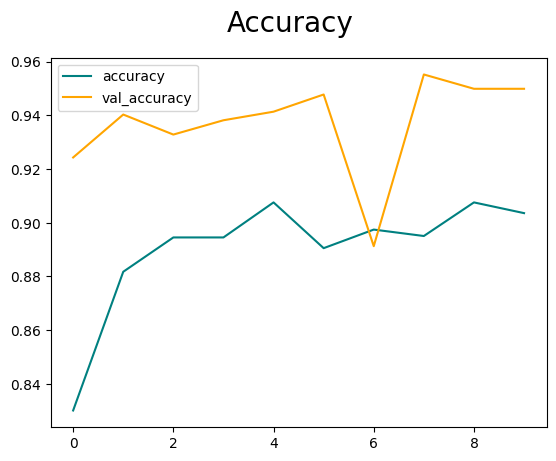

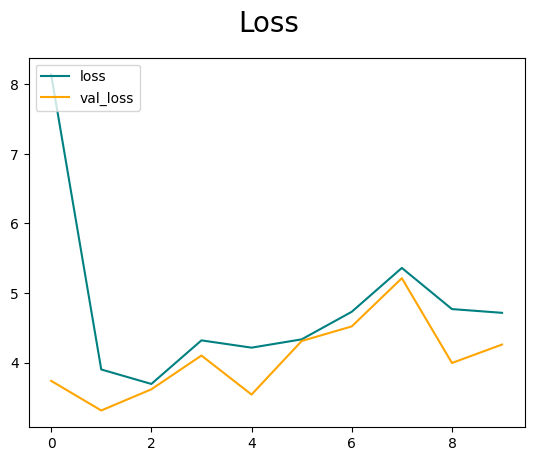

In [12]:
plot_accuracy_and_loss(history)

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
ResNet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape,pooling="avg")

for layer in ResNet50_base.layers:
    layer.trainable = False

ResNet50_model = transfer_learning_model(base_model=ResNet50_base)

# We need a different preprocessing method to apply appropriate caching to
# my model because if i use cache like before it can be problematic because
# of data augmentation, and if I do not use caching I cannot train with my
# gpu beacuse of its limitations. So I found that solution.
AUTOTUNE = tf.data.AUTOTUNE
CACHE_TRAIN = "/tmp/resnet50_train.cache"   
CACHE_VAL   = "/tmp/resnet50_val.cache"

def add_preprocess(ds):
    return ds.map(lambda x, y: (preprocess_input(x), y),
                  num_parallel_calls=AUTOTUNE)

CACHE_DIR = "/tmp/tf_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

train_ds = (add_preprocess(augmented_train_ds)
            .cache(os.path.join(CACHE_DIR, "train.cache"))
            .shuffle(1000)
            .prefetch(AUTOTUNE))

val_ds   = (add_preprocess(augmented_val_ds)
            .cache(os.path.join(CACHE_DIR, "val.cache"))
            .prefetch(AUTOTUNE))

history = ResNet50_model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

ResNet50_model.save("ResNet50_transfer_learning_model.h5")

Epoch 1/10


2025-05-09 00:58:58.349044: W tensorflow/core/kernels/data/cache_dataset_ops.cc:333] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
I0000 00:00:1746741538.358745   30044 service.cc:152] XLA service 0x7fa170012ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746741538.358792   30044 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-05-09 00:58:58.564827: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746741540.137024   30044 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-0

  5/470 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.3971 - loss: 6.6795 

I0000 00:00:1746741544.131861   30044 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 29/470 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.5558 - loss: 5.9478

2025-05-09 00:59:07.403417: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.172 = (f32[2,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,128,28,28]{3,2,1,0} %bitcast.8062, f32[128,128,3,3]{3,2,1,0} %bitcast.8069, f32[128]{0} %bitcast.8071), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv3_block1_2_conv_1/convolution" source_file="/home/tako/Documents/506hw/myenv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-09 00:59:07.667040: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm

470/470 ━━━━━━━━━━━━━━━━━━━━ 48s 66ms/step - accuracy: 0.8329 - loss: 3.1367 - val_accuracy: 0.9723 - val_loss: 0.7491
Epoch 2/10


2025-05-09 00:59:35.056157: W tensorflow/core/kernels/data/cache_dataset_ops.cc:333] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


470/470 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.9319 - loss: 0.7557 - val_accuracy: 0.9712 - val_loss: 0.4690
Epoch 3/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.9509 - loss: 0.4944 - val_accuracy: 0.9009 - val_loss: 0.6763
Epoch 4/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.9459 - loss: 0.4832 - val_accuracy: 0.9776 - val_loss: 0.3620
Epoch 5/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.9448 - loss: 0.4364 - val_accuracy: 0.9819 - val_loss: 0.3404
Epoch 6/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.9485 - loss: 0.4077 - val_accuracy: 0.9765 - val_loss: 0.3388
Epoch 7/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.9467 - loss: 0.3894 - val_accuracy: 0.9616 - val_loss: 0.3520
Epoch 8/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.9428 - loss: 0.4133 - val_accuracy: 0.9733 - val_loss: 0.3470
Epoch 9/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.9499 - loss: 0.3966 - val_accurac

In [ ]:
plot_accuracy_and_loss(history)

# Results 

Validation Accuracies
* My architecture: 0.74 -> data augmented 0.89
* VGG: 0.89 -> data augmented 0.95
* Resnet: 0.99 -> data augmented 0.98

We can observe the positive affect of data augmentation and transfer learning in here.
